In [12]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import gym
import tqdm
import matplotlib.pyplot as plt

In [13]:
# Actor 
# Make sure it takes varying input Dimensions
# This outputs a tensor of arrays if 2 states are passed to NN then the corresponding actions will be stacked across 
# the rows
# If 2 states are passed then .sample() return a actions from each of the 2 rows
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256):
        super(ActorNetwork, self).__init__()

        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), 'actor_lunarPPO.pt')

    def load_checkpoint(self):
        self.load_state_dict(T.load('actor_lunarPPO.pt'))

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            ):
        super(CriticNetwork, self).__init__()

        
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
    def forward(self, state):
        value = self.critic(state)
        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), 'critic_LunarPPO.pt')

    def load_checkpoint(self):
        self.load_state_dict(T.load('critic_LunarPPO.pt'))

In [14]:
# This will help in creating a traversal. Batches will be stacked and each batch will represent a traversal
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

In [15]:
# Initialize Actor and Critic

class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)
            values = T.tensor(values).to(self.actor.device)
            
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()

In [16]:
env = gym.make('LunarLander-v2')
N=300
batch_size = 100
n_epochs = 10
alpha = 0.0001
agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
                    alpha=alpha, n_epochs=n_epochs, 
                    input_dims=env.observation_space.shape)
num_eps = 6000
returns_d = []
lengths_d = []
gamma = 0.99  
learn_iter = 0
pbar = tqdm.trange(num_eps)
continuous_counter = 0
for t_total in pbar:
    done = False
    observation = env.reset()
    episode_length = 0
    rewards_d = []
    while not done:
        action,probs,val = agent.choose_action(observation)
        observation_,reward,done,info=env.step(action)
        rewards_d.append(reward)
        agent.remember(observation,action,probs,val,reward,done)
        if (continuous_counter+1) % N == 0:
            agent.learn()
            learn_iter += 1
        observation = observation_
        episode_length+=1
        continuous_counter+=1

    G = sum(rewards_d * (gamma ** np.arange(episode_length-1, -1, -1)))
    returns_d.append(G)
    lengths_d.append(episode_length)
    pbar.set_description(f'Episode: {t_total} | Steps: {episode_length} | Return: {G:5.2f} | Learn_iter: {learn_iter}' )

Episode: 5999 | Steps: 92 | Return: -11.04 | Learn_iter: 7891: 100%|██████████| 6000/6000 [1:49:05<00:00,  1.09s/it]    


In [17]:
np.save('PPO_returns.npy',returns_d)
np.save('PPO_length',lengths_d)

In [18]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

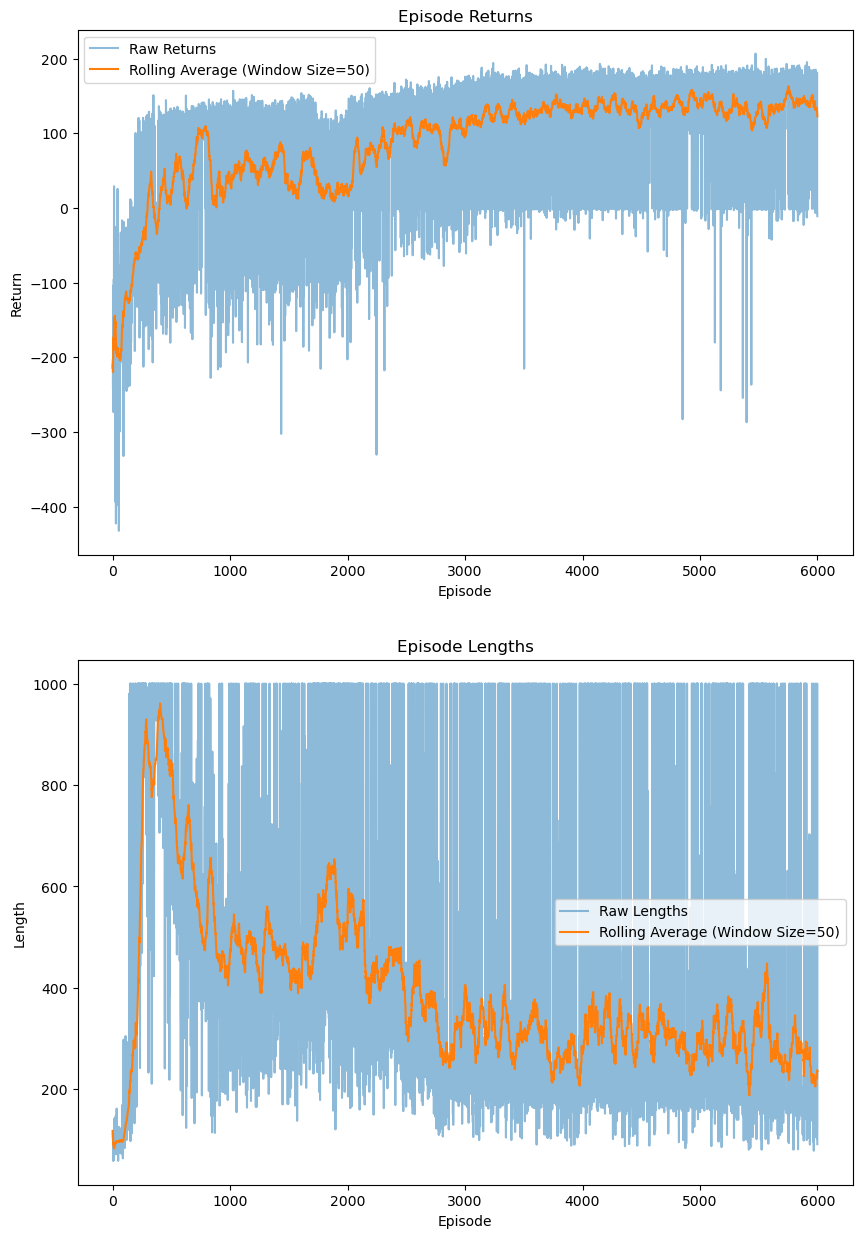

In [19]:
def plots(returns, lengths, window_size):
    # Calculate rolling averages
    smooth_returns = rolling_average(returns, window_size=window_size)
    smooth_lengths = rolling_average(lengths, window_size=window_size)

    fig, axes = plt.subplots(2, 1, figsize=(10, 15))

    # Plot Returns
    axes[0].plot(returns, label='Raw Returns', alpha=0.5)
    axes[0].plot(smooth_returns, label=f'Rolling Average (Window Size={window_size})')
    axes[0].set_title('Episode Returns')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Return')
    axes[0].legend()

    # Plot Lengths
    axes[1].plot(lengths, label='Raw Lengths', alpha=0.5)
    axes[1].plot(smooth_lengths, label=f'Rolling Average (Window Size={window_size})')
    axes[1].set_title('Episode Lengths')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Length')
    axes[1].legend()
    plt.show()

plots(np.array(returns_d), np.array(lengths_d), 5_0)

In [21]:
print("The max return is: ")
print(np.array(returns_d).max())
print("The min return is: ")
print(np.array(returns_d).min())
print("Average returns of last 1000 episodes: ")
print(np.array(returns_d)[-1:5000:-1].mean())

The max return is: 
206.66158014637836
The min return is: 
-432.4376036688241
Average returns of last 1000 episodes: 
134.96110103085235
